In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem import AllChem, Draw
from rdkit import Chem
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from IPython.display import display, Image

In [4]:
# fix random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)

In [5]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
plt.rcParams['font.size'] = 15
plt.rcParams['figure.dpi'] = 300
    
def histogram(df, col_name='k', axis_name='k', figsize = (14, 6)):
  """ visualize the distribution """
  fig, ax = plt.subplots(figsize = figsize)
  sns.histplot(data=df, x=col_name, bins=20, kde=True, ax=ax)
  ax.set_xlabel(f'{axis_name}', fontsize = 20)
  ax.set_ylabel(r'$\rm Frequency$', fontsize = 20)
  ax.tick_params(axis='x', labelsize=18)
  ax.tick_params(axis='y', labelsize=18)
  ax.grid(False)
  plt.show()

def show_smiles(smiles: list, count: int=10, molsPerRow: int=5):
  """generate 2D representations of the molecules"""
  # create a random number
  random_smiles_list = random.sample(list(range(len(smiles))), count)
  # Convert the SMILES strings to RDKit molecules
  molecules = [Chem.MolFromSmiles(smiles[smile_idx]) for smile_idx in random_smiles_list]

  # Draw the first molecules
  img = Draw.MolsToGridImage(molecules, molsPerRow=molsPerRow, subImgSize=(400,400), returnPNG=False).save("../reports/molecules.png")
  display(Image("../reports/molecules.png"))
  
def show_chemical_space(smiles: list, figsize = (14, 6)):
    """ Plot a t-SNE plot of the molecular fingerprints for a list of SMILES strings """
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    # Generate molecular fingerprints using Morgan algorithm with radius=2
    fps = np.asarray([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 2) for sm in smiles])
    tsne_ = TSNE(n_components=2)
    pca_ = PCA(n_components=2)
    umap_ = umap.UMAP(n_neighbors = 25, n_components = 2, low_memory = False, min_dist = 0.001)
    tsne_result = tsne_.fit_transform(fps)
    pca_result = pca_.fit_transform(fps)
    umap_result = umap_.fit_transform(fps)
    
    ax[0].scatter(pca_result[:,0], pca_result[:,1])
    ax[0].set_xlabel(r'$\rm PCA \ 1$', fontsize=20)
    ax[0].set_ylabel(r'$\rm PCA \ 2$', fontsize=20)
    ax[0].tick_params(axis='x', labelsize=18)
    ax[0].tick_params(axis='y', labelsize=18)
    ax[0].grid(False)
    
    ax[1].scatter(tsne_result[:,0], tsne_result[:,1])
    ax[1].set_xlabel(r'$\rm tSNE \ 1$', fontsize=20)
    ax[1].set_ylabel(r'$\rm tSNE \ 2$', fontsize=20)
    ax[1].tick_params(axis='x', labelsize=18)
    ax[1].tick_params(axis='y', labelsize=18)
    ax[1].grid(False)
    
    ax[2].scatter(umap_result[:,0], umap_result[:,1])
    ax[2].set_xlabel(r'$\rm UMAP \ 1$', fontsize=20)
    ax[2].set_ylabel(r'$\rm UMAP \ 2$', fontsize=20)
    ax[2].tick_params(axis='x', labelsize=18)
    ax[2].tick_params(axis='y', labelsize=18)
    ax[2].grid(False)
    
    plt.tight_layout()
    plt.show()

# Data for property model
source: htttps

In [6]:
redox_potential = pd.read_csv('../data/data.csv')
redox_potential.head()

,smiles,redox_potential
0,NC=O,6.12
1,CN(C)C=O,4.93
2,CN(C)C(C)=O,4.74
3,CNC(C)=O,5.32
4,CC(N)=O,6.00


In [7]:
redox_potential['NumAtoms'] = redox_potential['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
redox_potential.head()

,smiles,redox_potential,NumAtoms
0,NC=O,6.12,3
1,CN(C)C=O,4.93,5
2,CN(C)C(C)=O,4.74,6
3,CNC(C)=O,5.32,5
4,CC(N)=O,6.00,4


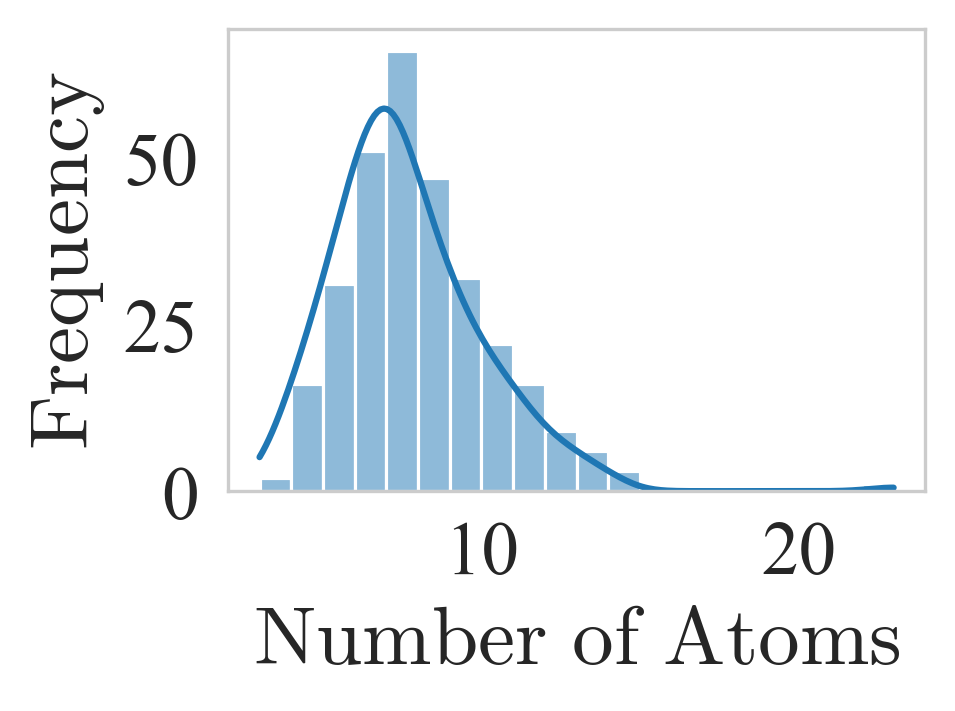

In [8]:
histogram(redox_potential, col_name='NumAtoms', axis_name=r'$\rm Number \ of \ Atoms$', figsize = (3, 2))

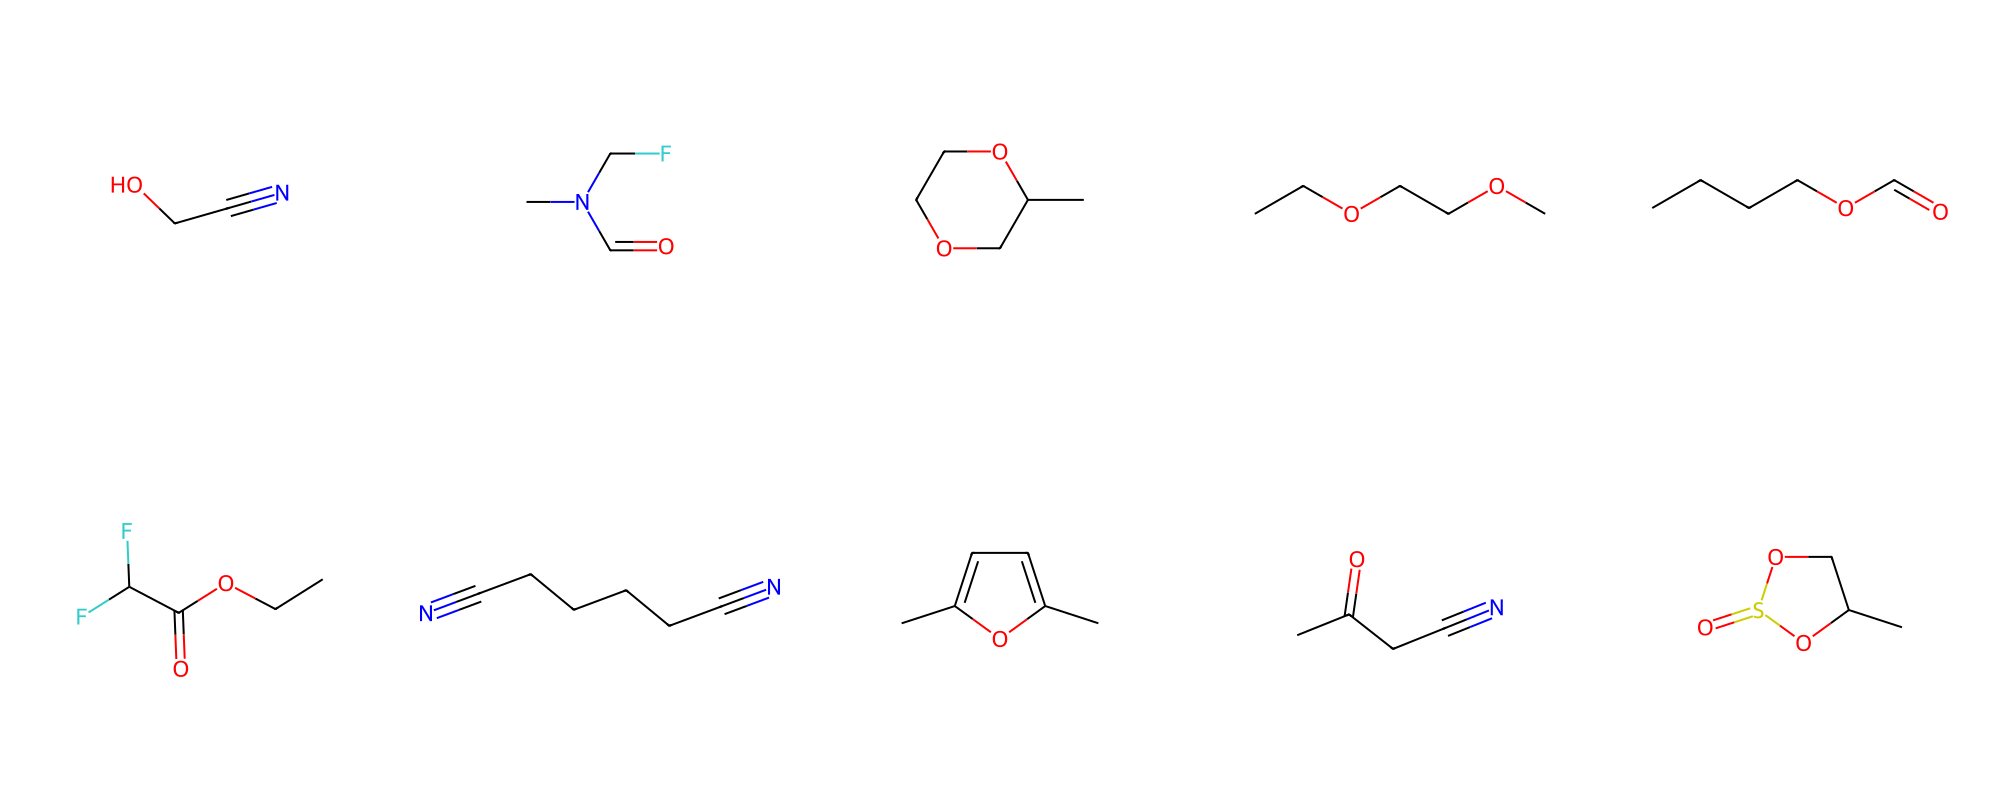

In [9]:
show_smiles(smiles=redox_potential['smiles'], count=10, molsPerRow=5)

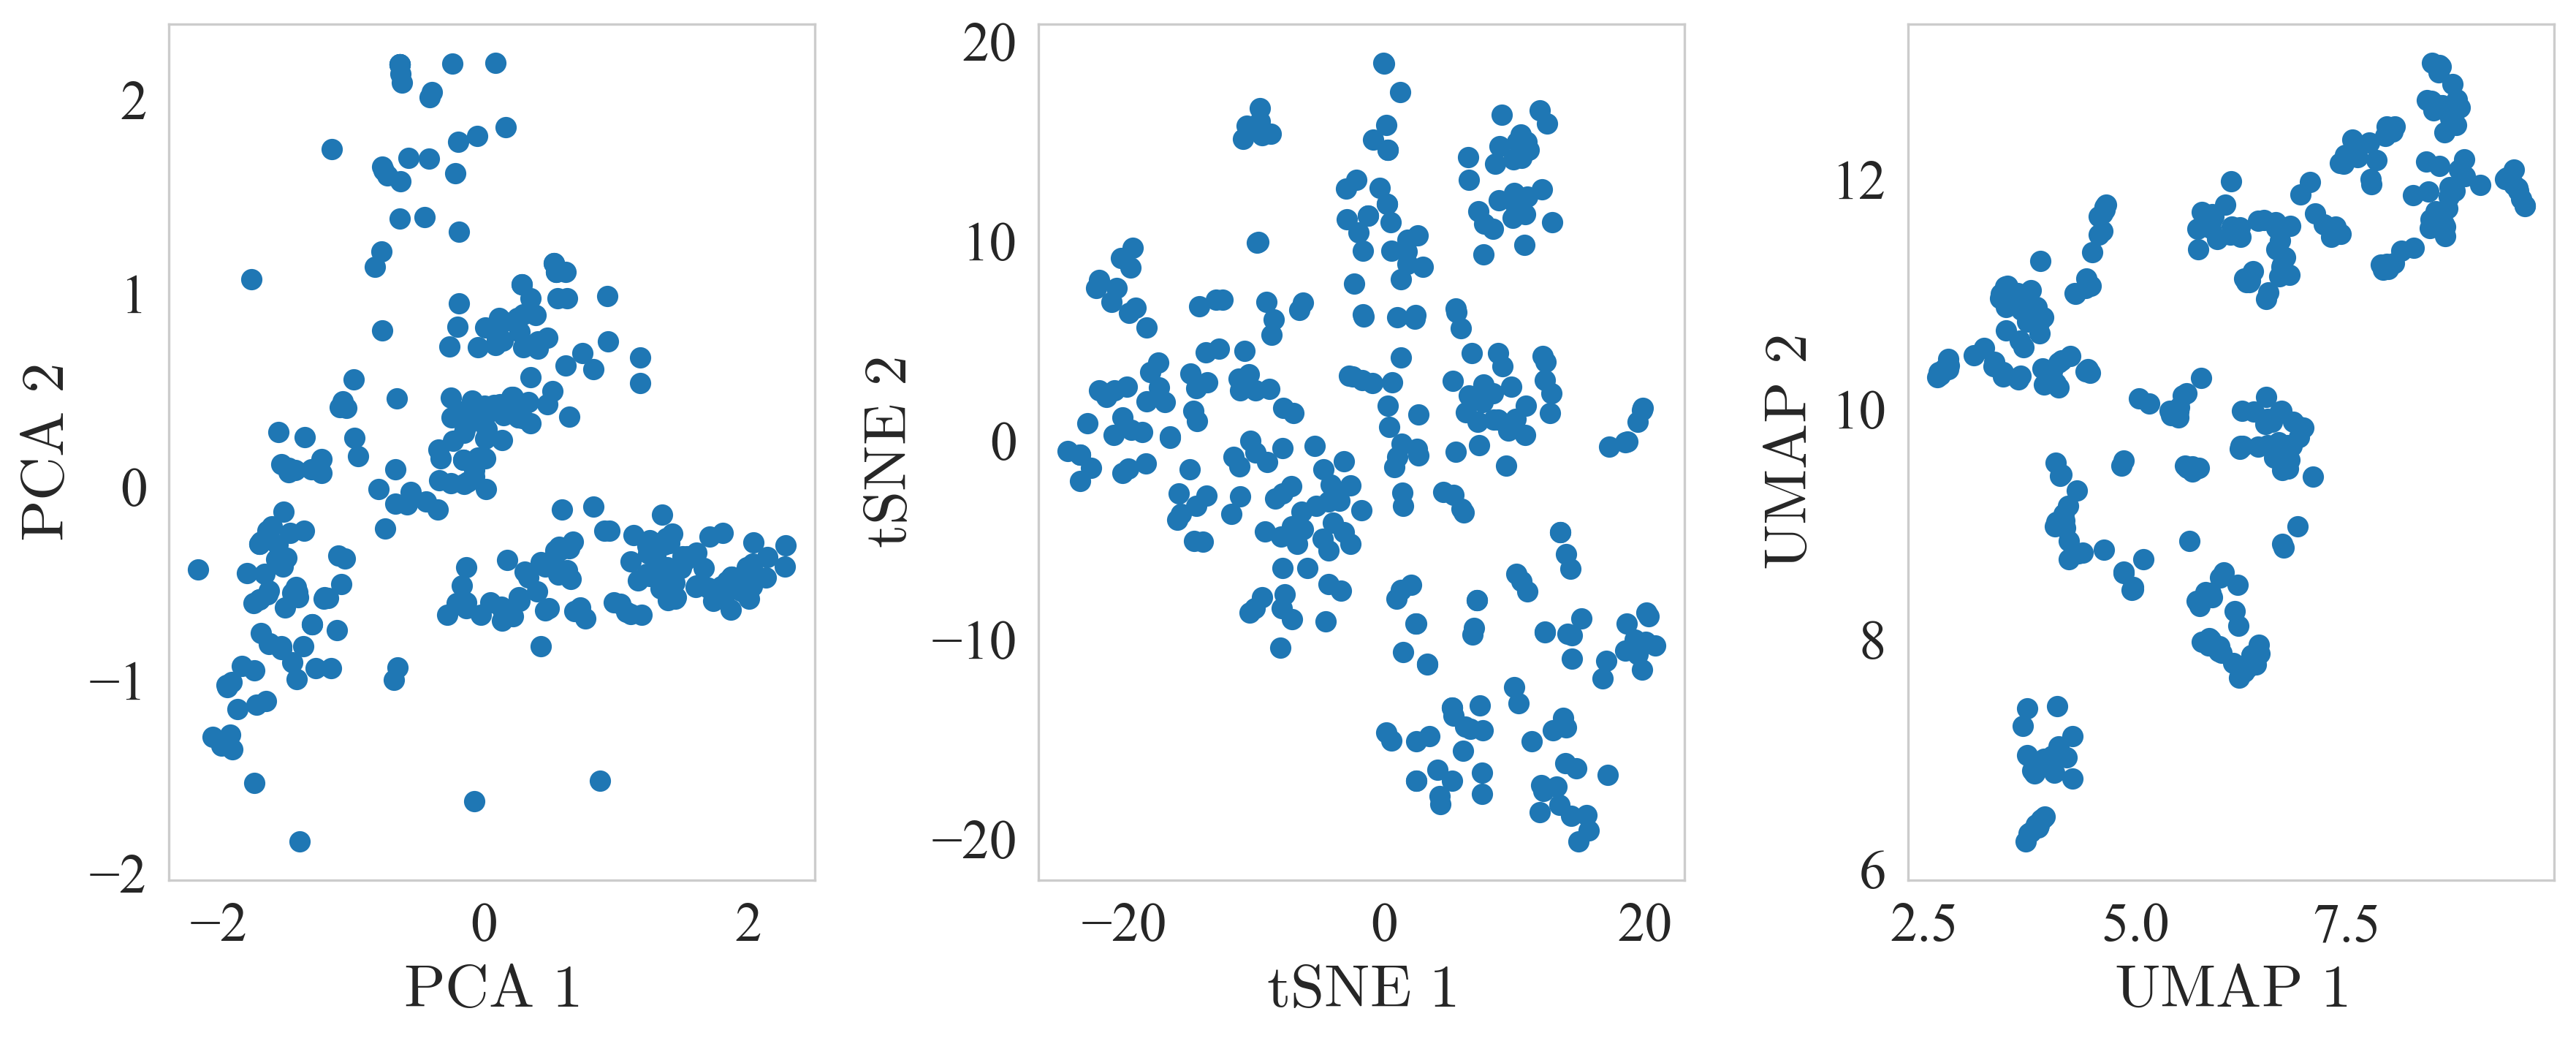

In [10]:
show_chemical_space(redox_potential.smiles, figsize = (12, 5))

# Solvent - for pretraining VAE
references: 
<ol>
<li>https://github.com/zavalab/ML/blob/SolvGNN/solvgnn/data/solvent_list_ref.csv</li>
<li>https://pubs.rsc.org/en/content/articlehtml/2022/dd/d2dd00045h</li>
</ol>

In [11]:
vae_pretain_data = pd.read_csv('../data/solvent.csv')
vae_pretain_data.columns = ['name', 'identifier', 'smiles']
vae_pretain_data.head() 

,name,identifier,smiles
0,"1,1,1-TRICHLOROETHANE",solvent_1,CC(Cl)(Cl)Cl
1,"1,1,1-TRIFLUOROETHANE",solvent_2,CC(F)(F)F
2,"1,1,2,2-TETRABROMOETHANE",solvent_3,BrC(Br)C(Br)Br
3,"1,1,2,2-TETRACHLOROETHANE",solvent_4,ClC(Cl)C(Cl)Cl
4,"1,1,2,2-TETRACHLOROPROPANE",solvent_5,CC(Cl)(Cl)C(Cl)Cl


In [12]:
vae_pretain_data['NumAtoms'] = vae_pretain_data['smiles'].apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
vae_pretain_data.head()

,name,identifier,smiles,NumAtoms
0,"1,1,1-TRICHLOROETHANE",solvent_1,CC(Cl)(Cl)Cl,5
1,"1,1,1-TRIFLUOROETHANE",solvent_2,CC(F)(F)F,5
2,"1,1,2,2-TETRABROMOETHANE",solvent_3,BrC(Br)C(Br)Br,6
3,"1,1,2,2-TETRACHLOROETHANE",solvent_4,ClC(Cl)C(Cl)Cl,6
4,"1,1,2,2-TETRACHLOROPROPANE",solvent_5,CC(Cl)(Cl)C(Cl)Cl,7


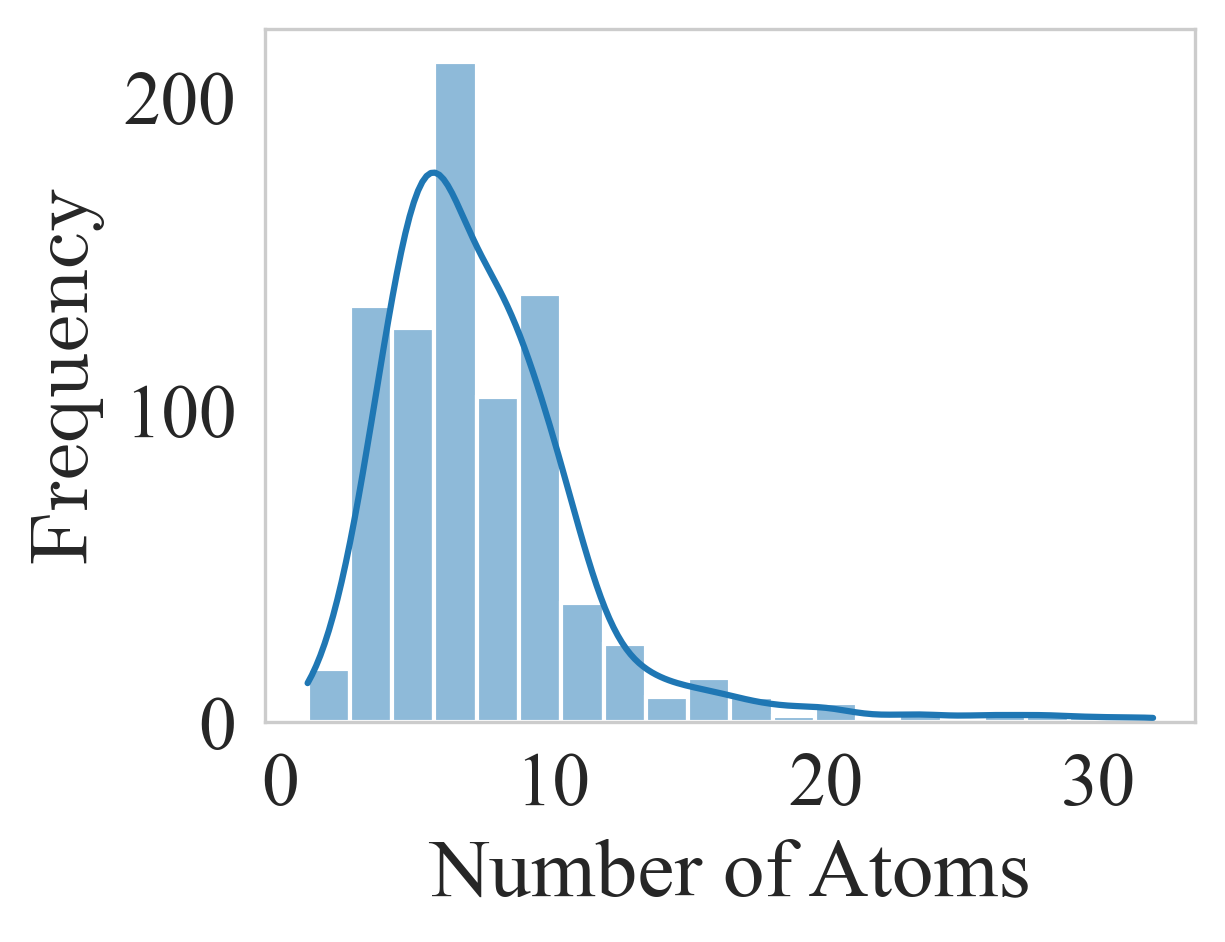

In [13]:
histogram(df=vae_pretain_data, col_name='NumAtoms', axis_name='Number of Atoms', figsize = (4, 3))

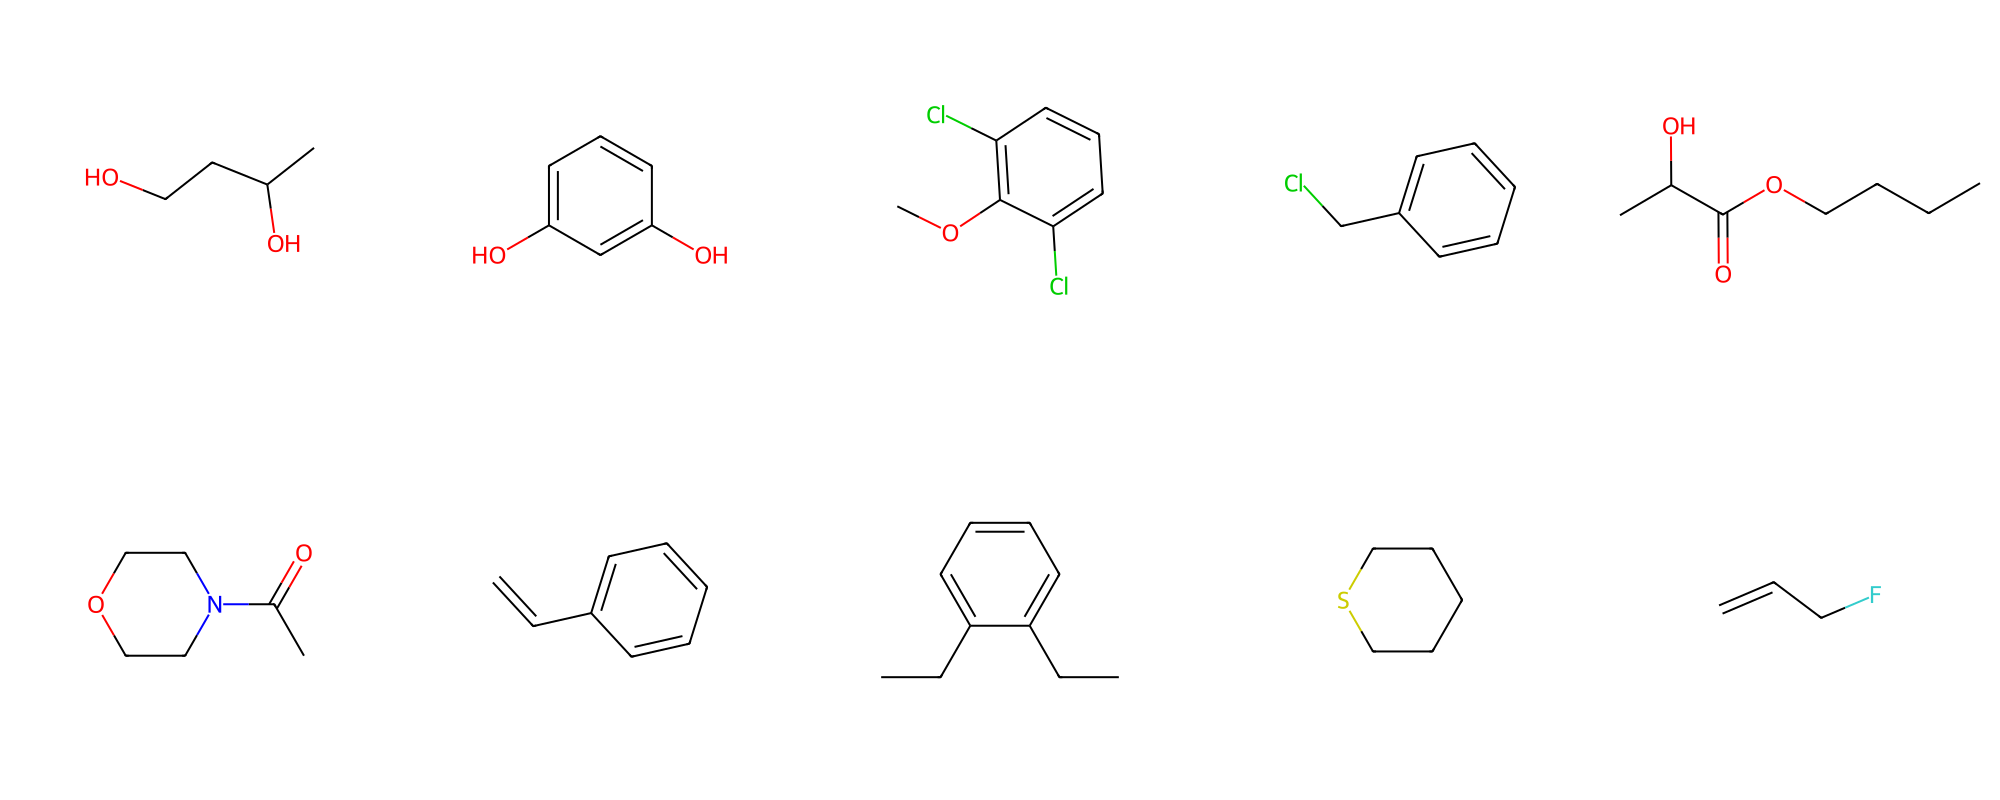

In [14]:
show_smiles(smiles=vae_pretain_data['smiles'], count=10, molsPerRow=5)

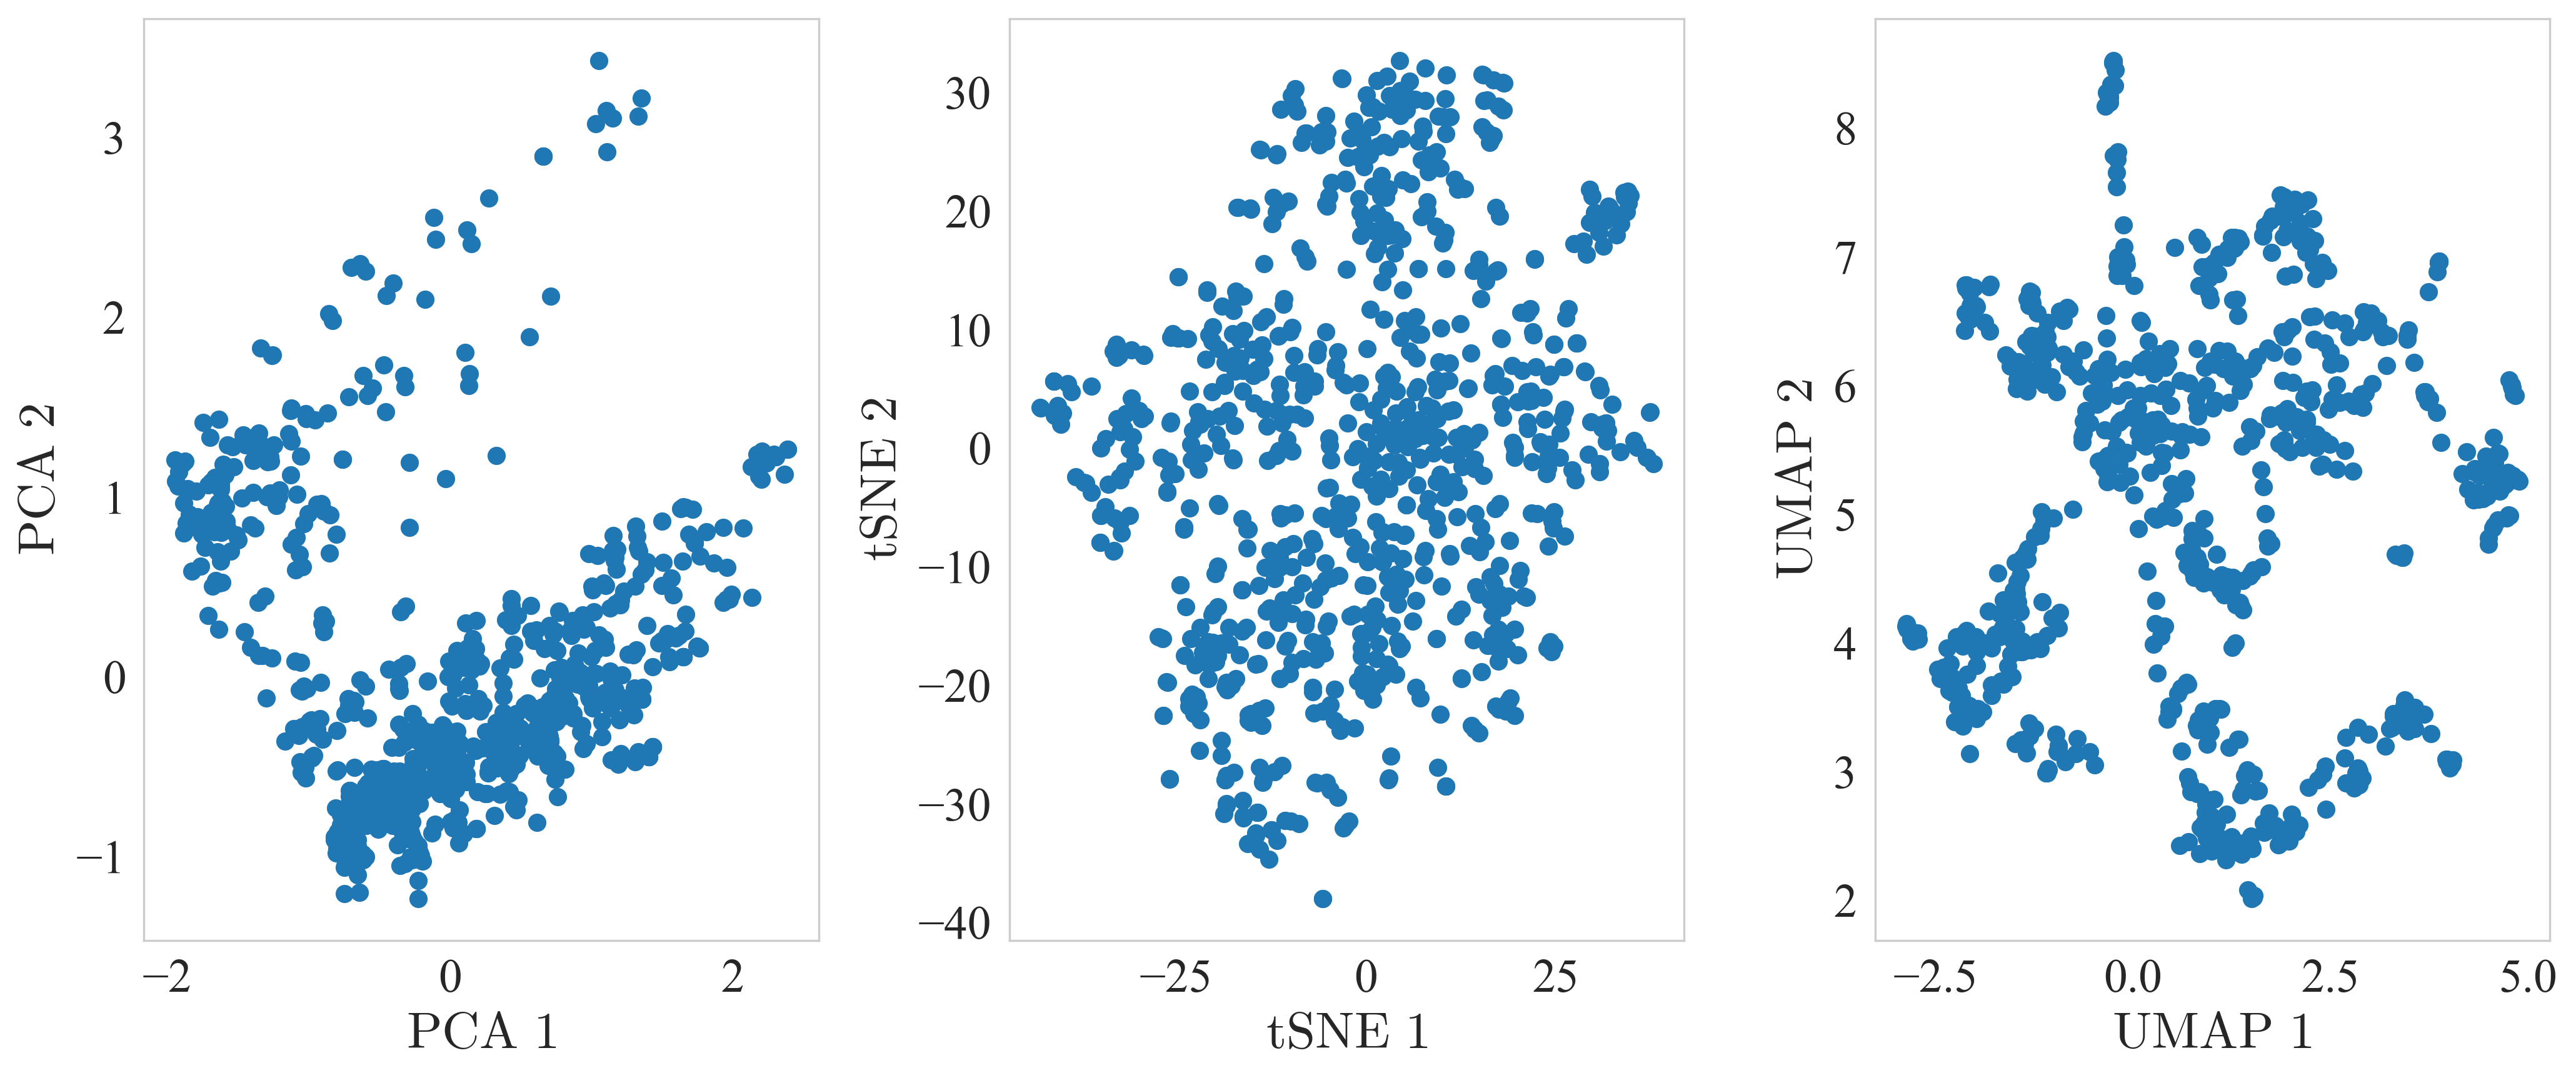

In [15]:
show_chemical_space(smiles=vae_pretain_data.smiles, figsize = (14, 6))

# Project them together

In [16]:
def show_both_chemical_space(figsize = (14, 6),
                        redox_potential=list(redox_potential.smiles), 
                             vae_pretain_data=list(vae_pretain_data.smiles)):
    """
    Plot a t-SNE plot of the molecular fingerprints for a list of SMILES strings
    params:
            redox_potential: a list of SMILES strings
            vae_pretain_data: a list of SMILES strings
    returns:
    fig: matplotlib figure of scatter plot and make sure they are legende based on input parameters
    """
    fig, ax = plt.subplots(1, 3, facecolor='w', figsize=figsize)
    # Generate molecular fingerprints using Morgan algorithm with radius=2
    smiles = redox_potential + vae_pretain_data # merge into 1 list
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 2) for sm in smiles]
    # Convert the list of fingerprints to a numpy array
    fps = np.asarray([AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(sm), 2) for sm in smiles])
    tsne_ = TSNE(n_components=2)
    pca_ = PCA(n_components=2)
    umap_ = umap.UMAP(n_neighbors = 25, n_components = 2, low_memory = False, min_dist = 0.001)
    tsne_result = tsne_.fit_transform(fps)
    pca_result = pca_.fit_transform(fps)
    umap_result = umap_.fit_transform(fps)
    
    # index redox_potential and then vae_pretrain_data
    redox_potential_pos = range(len(redox_potential))
    vae_pretain_pos = range(len(redox_potential), len(redox_potential)+len(vae_pretain_data))
    
    ax[0].scatter(pca_result[redox_potential_pos][:, 0], pca_result[redox_potential_pos][:, 1], label='FT')
    ax[0].scatter(tsne_result[vae_pretain_pos][:,0], tsne_result[vae_pretain_pos][:,1], label = 'PT')
    ax[0].set_xlabel(r'$\rm PCA \ 1$', fontsize = 20)
    ax[0].set_ylabel(r'$\rm PCA \ 2$', fontsize = 20)
    ax[0].tick_params(axis='x', labelsize=18)
    ax[0].tick_params(axis='y', labelsize=18)
    ax[0].grid(False)
    
    ax[1].scatter(tsne_result[redox_potential_pos][:,0], tsne_result[redox_potential_pos][:,1], label='FT')
    ax[1].scatter(tsne_result[vae_pretain_pos][:,0], tsne_result[vae_pretain_pos][:,1], label='PT')
    ax[1].set_xlabel(r'$\rm tSNE \ 1$', fontsize=20)
    ax[1].set_ylabel(r'$\rm tSNE \ 2$', fontsize=20)
    ax[1].tick_params(axis='x', labelsize=18)
    ax[1].tick_params(axis='y', labelsize=18)
    ax[1].grid(False)
    ax[1].legend(loc='best', frameon=True, shadow=True)
    
    ax[2].scatter(umap_result[redox_potential_pos][:,0], umap_result[redox_potential_pos][:,1], label='FT')
    ax[2].scatter(umap_result[vae_pretain_pos][:, 0], umap_result[vae_pretain_pos][:,1], label='PT')
    ax[2].set_xlabel(r'$\rm UMAP \ 1$', fontsize=20)
    ax[2].set_ylabel(r'$\rm UMAP \ 2$', fontsize=20)
    ax[2].tick_params(axis='x', labelsize=18)
    ax[2].tick_params(axis='y', labelsize=18)
    ax[2].grid(False)
    
    plt.tight_layout()
    plt.show()

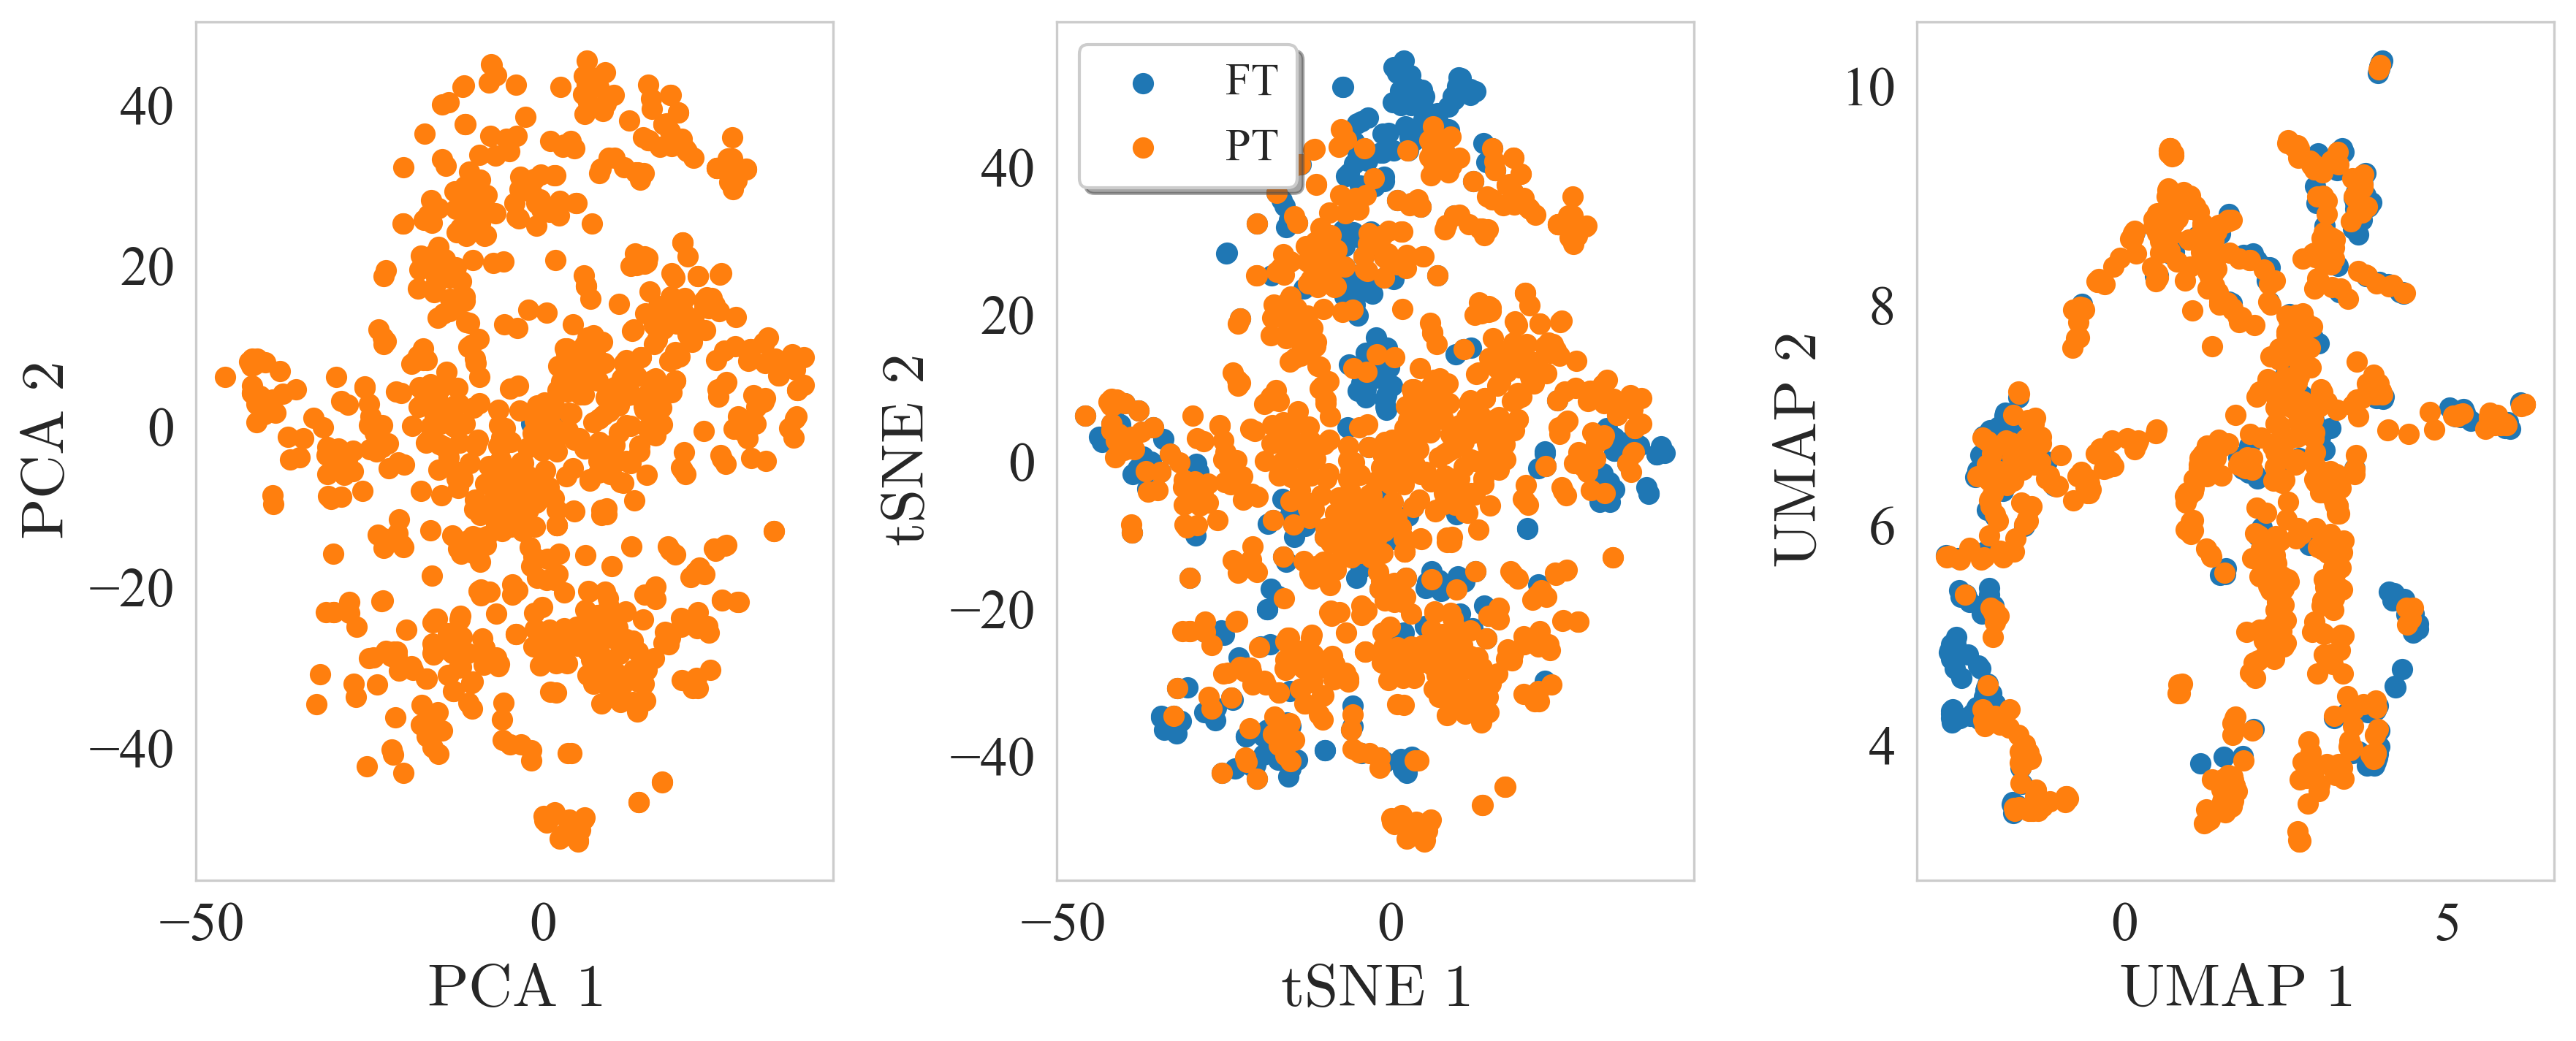

In [17]:
show_both_chemical_space(figsize = (12, 5))